In [24]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from scipy.stats import mode

In [3]:
# Load datasets
train_dir = "train.csv"
test_dir = "test.csv"

# Read the data
train_data = pd.read_csv(train_dir)
#test_data = pd.read_csv(test_dir)

In [4]:
# Global dictionaries for storing encoders
label_encoders = {}

# Path to save/load the scaler
# In case test data has different distribution, we need to scale it using the same scaler as train data
# Exp: Train data has Age from 0-100, but test data has Age from 0-80. We need to scale both to 0-1 range.
scaler_path = "scaler.pkl"
standard_scaler_path = "standard_scaler.pkl"  # Path to save/load standard scaler

In [5]:
if 'Bed Grade' in train_data.columns and train_data['Bed Grade'].isnull().sum() > 0:
    train_data['Bed Grade'].fillna(train_data['Bed Grade'].mode()[0], inplace=True)
if 'City_Code_Patient' in train_data.columns and train_data['City_Code_Patient'].isnull().sum() > 0:
    train_data['City_Code_Patient'].fillna(train_data['City_Code_Patient'].mode()[0], inplace=True)

# Ensure Bed Grade and City Code are integers
if 'Bed Grade' in train_data.columns:
    train_data['Bed Grade'] = train_data['Bed Grade'].astype(int)
if 'City_Code_Patient' in train_data.columns:
    train_data['City_Code_Patient'] = train_data['City_Code_Patient'].astype(int)

In [6]:
train_data.drop(columns=[col for col in ['case_id', 'patientid'] if col in train_data.columns], inplace=True)

In [7]:
stay_mapping = {
    '0-10': 1, '11-20': 2, '21-30': 3, '31-40': 4, '41-50': 5,
    '51-60': 6, '61-70': 7, '71-80': 8, '81-90': 9, '91-100': 10,
    '100 Days': 10, 'More than 100 Days': 11
}
train_data['Stay'] = train_data['Stay'].map(stay_mapping)

In [8]:
# Convert categorical variables using the specified mappings
if 'Hospital_type_code' in train_data.columns:
    train_data['Hospital_type_code'] = train_data['Hospital_type_code'].map(lambda x: ord(x.lower()) - ord('a') + 1)
if 'Ward_Facility_Code' in train_data.columns:
    train_data['Ward_Facility_Code'] = train_data['Ward_Facility_Code'].map(lambda x: ord(x) - ord('A') + 1)
if 'Hospital_region_code' in train_data.columns:
    region_mapping = {'X': 1, 'Y': 2, 'Z': 3}
    train_data['Hospital_region_code'] = train_data['Hospital_region_code'].map(region_mapping)
if 'Ward_Type' in train_data.columns:
    train_data['Ward_Type'] = train_data['Ward_Type'].map(lambda x: ord(x) - ord('P') + 1)
if 'Type of Admission' in train_data.columns:
    admission_mapping = {'Trauma': 1, 'Urgent': 2, 'Emergency': 3}
    train_data['Type of Admission'] = train_data['Type of Admission'].map(admission_mapping)
if 'Severity of Illness' in train_data.columns:
    severity_mapping = {'Minor': 1, 'Moderate': 2, 'Extreme': 3}
    train_data['Severity of Illness'] = train_data['Severity of Illness'].map(severity_mapping)

In [9]:
label_encoders = {}

# Label Encode Age by decade
if 'Age' in train_data.columns:
    le = LabelEncoder()
    train_data['Age'] = le.fit_transform(train_data['Age'])
    label_encoders['Age'] = le

# Label Encode Department
if 'Department' in train_data.columns:
    le = LabelEncoder()
    train_data['Department'] = le.fit_transform(train_data['Department'])
    label_encoders['Department'] = le

In [10]:
# Convert categorical variables using the specified mappings
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient']
for col in categorical_codes:
    if col in train_data.columns:
        train_data[col] = train_data[col].astype(str)

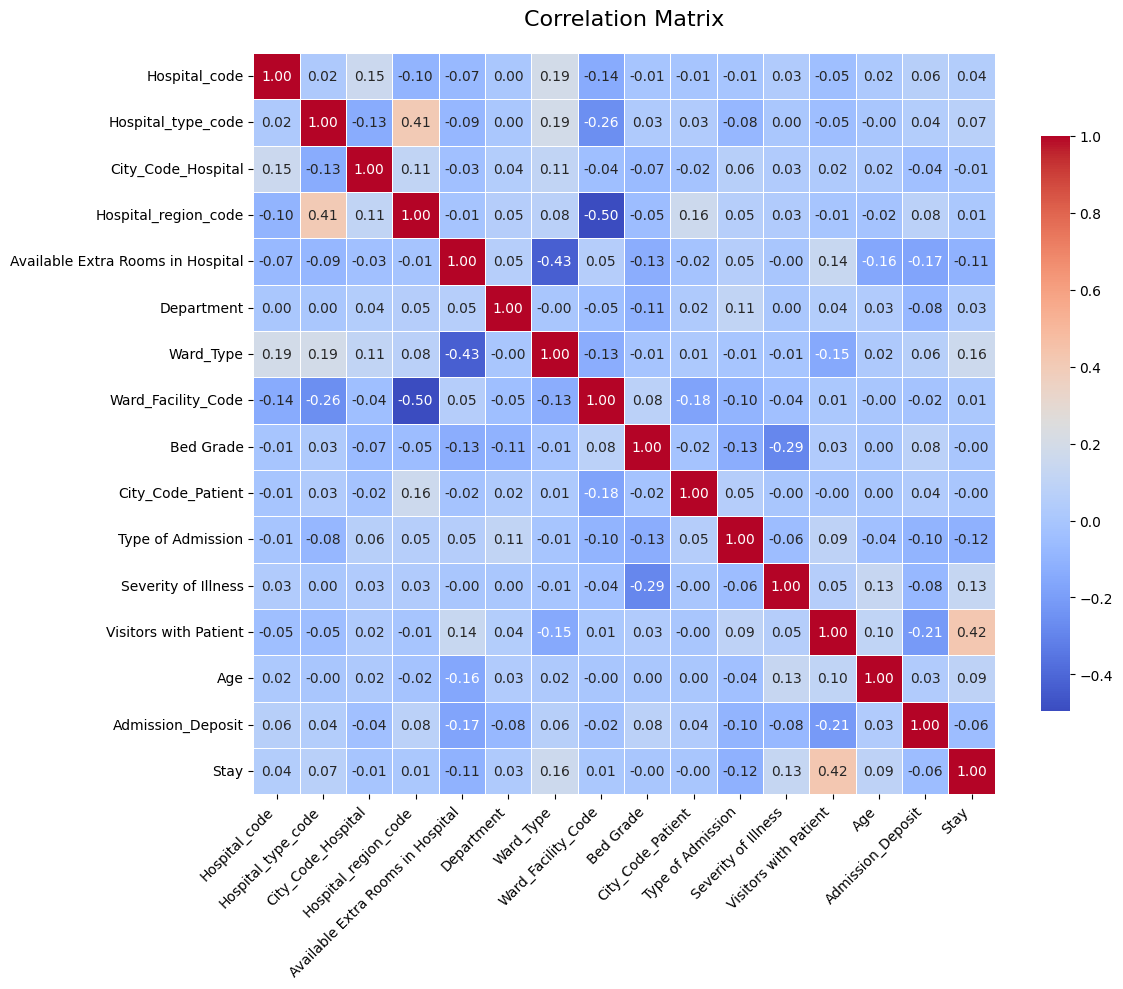

In [ ]:
#correlation matrix with all features
correlation_matrix = train_data.corr(method='spearman')



plt.figure(figsize=(12, 10))  

sns.heatmap(
        correlation_matrix,
        annot=True,               
        fmt=".2f",                
        cmap='coolwarm',         
        linewidths=0.5,           
        square=True,              
        cbar_kws={"shrink": 0.75} 
    )

    
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)              
plt.title("Correlation Matrix", fontsize=16, pad=20)

plt.tight_layout() 
plt.show()


Nothing seems to have a strong linear correlation with stay, but that doesnt mean there isnt a correlation, might be nonlinear 

We are going to try a benchmark model with and without these features:hospital code, department,  hospital type code, city code hospital, ward type, city code patient, hospital region code, and ward facility code 

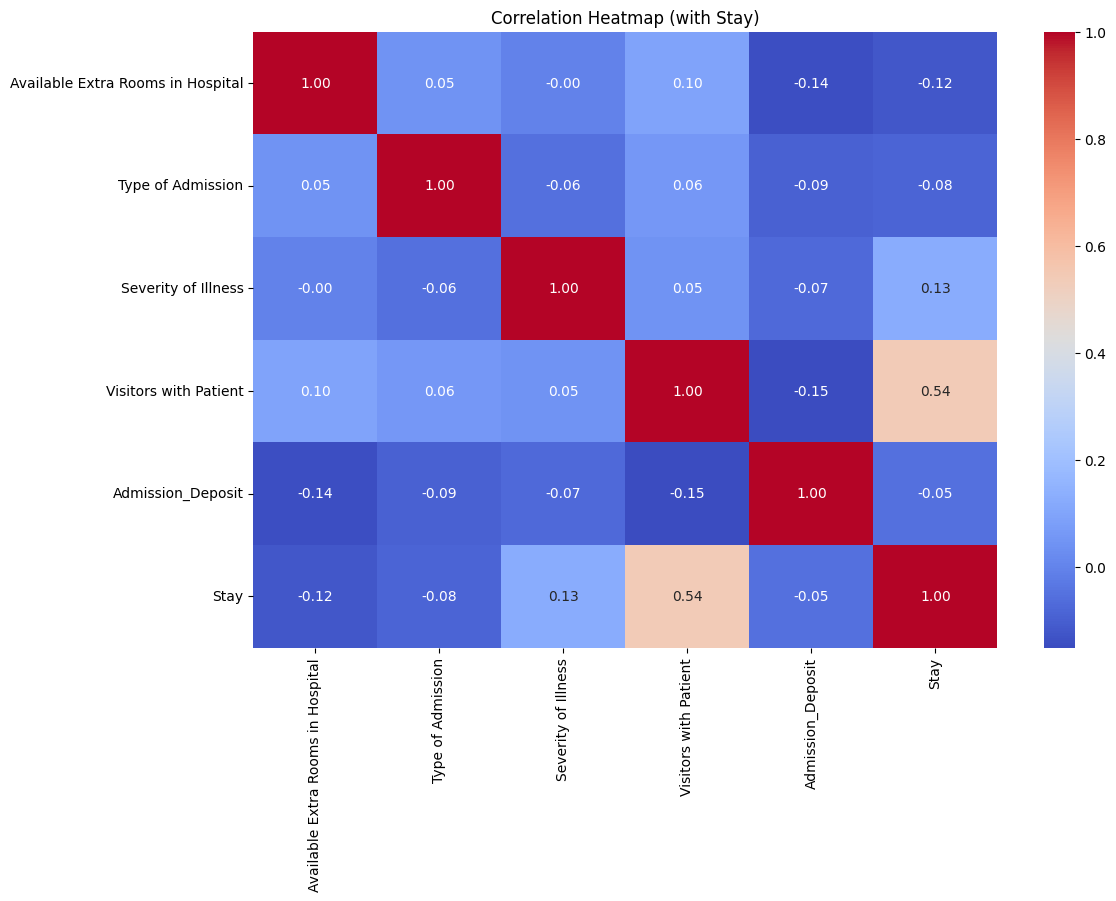

In [ ]:
#correlation matrix with just numeric 
numeric_train_data = train_data.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(12, 8))
corr_matrix = numeric_train_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (with Stay)')
plt.show()

In [11]:
# One-hot encode categorical columns
categorical_codes = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 'Department', 'Ward_Facility_Code', 'Hospital_region_code', 'Ward_Type', 'City_Code_Patient', 'Stay']
train_data_encoded = pd.get_dummies(train_data, columns=categorical_codes, drop_first=False)

In [ ]:
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)       

In [ ]:
log_reg = LogisticRegression(max_iter=200, solver='saga', n_jobs=1)
log_reg.fit(X_train_scaled, y_train)  


y_pred_log_reg = log_reg.predict(X_test_scaled)  


print("Logistic Regression (All Features)")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))  

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg)) 


Logistic Regression (All Features)
Accuracy: 0.3824896369802789

Classification Report:
              precision    recall  f1-score   support

           1       0.44      0.03      0.06      4721
           2       0.37      0.42      0.39     15628
           3       0.40      0.66      0.50     17498
           4       0.34      0.20      0.25     11032
           5       0.00      0.00      0.00      2349
           6       0.36      0.47      0.41      7004
           7       0.00      0.00      0.00       549
           8       0.00      0.00      0.00      2051
           9       0.00      0.00      0.00       967
          10       0.00      0.00      0.00       553
          11       0.54      0.34      0.42      1336

    accuracy                           0.38     63688
   macro avg       0.22      0.19      0.19     63688
weighted avg       0.34      0.38      0.34     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [78]:
# Dummy Classifier (Most Frequent Class)
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)
y_pred_dummy = dummy_clf.predict(X_test_scaled)

In [79]:
print("\nDummy Classifier (Most Frequent Class)")
print("Accuracy:", accuracy_score(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))


Dummy Classifier (Most Frequent Class)
Accuracy: 0.2747456349704811
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4721
           2       0.00      0.00      0.00     15628
           3       0.27      1.00      0.43     17498
           4       0.00      0.00      0.00     11032
           5       0.00      0.00      0.00      2349
           6       0.00      0.00      0.00      7004
           7       0.00      0.00      0.00       549
           8       0.00      0.00      0.00      2051
           9       0.00      0.00      0.00       967
          10       0.00      0.00      0.00       553
          11       0.00      0.00      0.00      1336

    accuracy                           0.27     63688
   macro avg       0.02      0.09      0.04     63688
weighted avg       0.08      0.27      0.12     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

K means clustering

c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

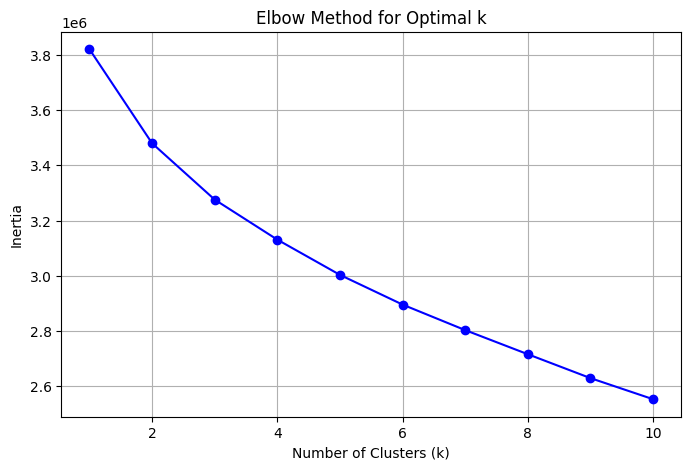

In [28]:
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled) 
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


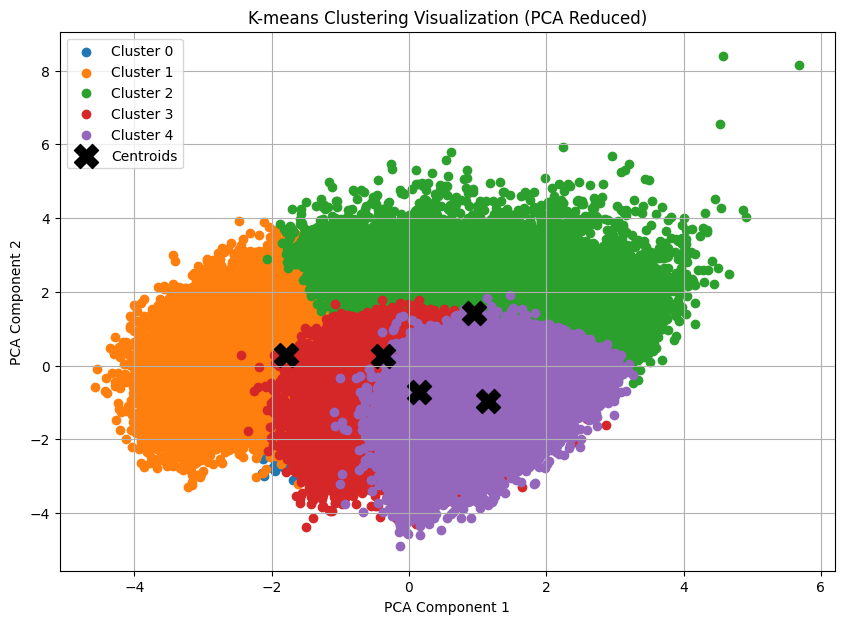

In [29]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  

clusters = kmeans.fit_predict(X_train_scaled)

# Convert `X_train_scaled` back to a DataFrame with correct column names
feature_names = train_data.drop(columns=['Stay']).columns  # Extract original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)

# Add the assigned cluster labels
X_train_scaled_df['Cluster'] = clusters


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_train_scaled)


X_train_scaled_df['PCA1'] = pca_components[:, 0]
X_train_scaled_df['PCA2'] = pca_components[:, 1]


plt.figure(figsize=(10, 7))

for cluster in range(optimal_k):
    plt.scatter(
        X_train_scaled_df[X_train_scaled_df['Cluster'] == cluster]['PCA1'],
        X_train_scaled_df[X_train_scaled_df['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}'
    )


centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=300, c='black', marker='X', label='Centroids')

plt.title('K-means Clustering Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_train_scaled)  


y_pred_clusters = kmeans.predict(X_test_scaled)  


labels_map = {}


for cluster in range(10):
    mask = (kmeans.labels_ == cluster)  
    if np.sum(mask) > 0:
        majority_label = mode(y_train[mask], keepdims=True).mode[0]  
        labels_map[cluster] = majority_label

y_pred_mapped = np.array([labels_map[cluster] for cluster in y_pred_clusters])


accuracy = accuracy_score(y_test, y_pred_mapped)
print(f'K-Means Clustering Accuracy: {accuracy:.2f}')


print("\nClassification Report:")
print(classification_report(y_test, y_pred_mapped))




c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Clustering Accuracy: 0.29

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4721
           2       0.26      0.24      0.25     15628
           3       0.30      0.79      0.43     17498
           4       0.00      0.00      0.00     11032
           5       0.00      0.00      0.00      2349
           6       0.00      0.00      0.00      7004
           7       0.00      0.00      0.00       549
           8       0.00      0.00      0.00      2051
           9       0.00      0.00      0.00       967
          10       0.00      0.00      0.00       553
          11       0.28      0.45      0.35      1336

    accuracy                           0.29     63688
   macro avg       0.08      0.13      0.09     63688
weighted avg       0.15      0.29      0.19     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [30]:

optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)


X_scaled_df = pd.DataFrame(X_train, columns=X_train.columns)


X_scaled_df['Cluster'] = kmeans.fit_predict(X_train)



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [31]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=X_train.columns)


inertia_value = kmeans.inertia_


labels = kmeans.labels_


cluster_sizes = pd.Series(labels).value_counts().sort_index()

cluster_stats = {
    "Cluster Centers": cluster_centers,
    "Inertia": inertia_value,
    "Cluster Sizes": cluster_sizes
}

cluster_stats


{'Cluster Centers':    Hospital_code  Hospital_type_code  City_Code_Hospital  \
 0      18.056780            2.243184            4.842832   
 1      18.865636            2.279789            4.600569   
 2      18.584744            2.310907            4.668193   
 3      18.832716            2.260611            4.706156   
 4      17.660819            2.140351            5.009285   
 
    Hospital_region_code  Available Extra Rooms in Hospital  Department  \
 0              1.741604                           3.317069    1.972377   
 1              1.846279                           2.954941    1.872224   
 2              1.829640                           3.054252    1.938337   
 3              1.839432                           3.022901    1.823590   
 4              1.674926                           3.509131    1.995537   
 
    Ward_Type  Ward_Facility_Code  Bed Grade  City_Code_Patient  \
 0   2.841790            4.300939   2.567567           7.169053   
 1   2.952962            4.

Random Forest

In [32]:

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_scaled, y_train)  


y_pred = rf_classifier.predict(X_test_scaled)  


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.17      0.21      4721
           2       0.39      0.44      0.41     15628
           3       0.41      0.54      0.47     17498
           4       0.34      0.27      0.30     11032
           5       0.09      0.02      0.04      2349
           6       0.39      0.45      0.42      7004
           7       0.07      0.01      0.02       549
           8       0.26      0.09      0.14      2051
           9       0.38      0.20      0.26       967
          10       0.24      0.05      0.08       553
          11       0.53      0.46      0.49      1336

    accuracy                           0.38     63688
   macro avg       0.31      0.25      0.26     63688
weighted avg       0.36      0.38      0.36     63688



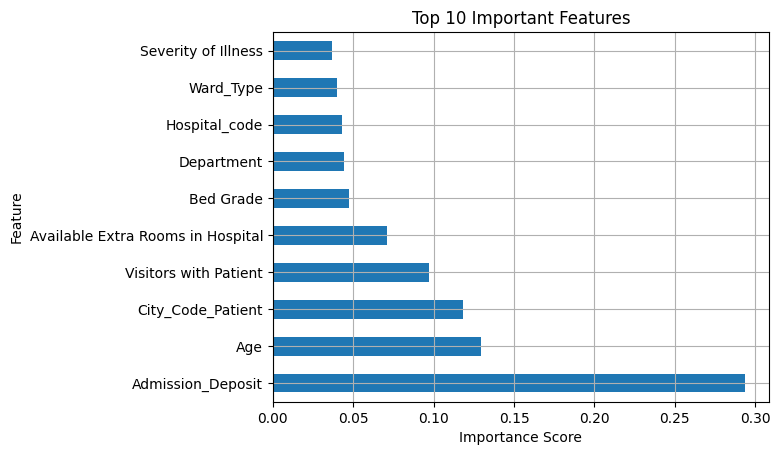

In [33]:
feature_names = train_data.drop(columns=['Stay']).columns  


X_test_final_df = pd.DataFrame(X_test_scaled, columns=feature_names)


feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_test_final_df.columns)
feature_importances.nlargest(10).plot(kind='barh')


plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

HPO Tuning

In [ ]:
# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],        
    'max_depth': [None, 10, 20, 30],       
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4],        
    'max_features': ['sqrt', 'log2'],      
}

# Initialize Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=5,  # 5-Fold Cross Validation
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate Best Model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)


rf_classifier.fit(X_train_scaled, y_train)

y_pred = rf_classifier.predict(X_test_scaled)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.42

Classification Report:
              precision    recall  f1-score   support

           1       0.40      0.13      0.20      4721
           2       0.42      0.49      0.46     15628
           3       0.42      0.66      0.52     17498
           4       0.43      0.23      0.30     11032
           5       0.50      0.00      0.00      2349
           6       0.40      0.52      0.45      7004
           7       0.00      0.00      0.00       549
           8       0.41      0.02      0.03      2051
           9       0.48      0.12      0.19       967
          10       0.00      0.00      0.00       553
          11       0.55      0.43      0.48      1336

    accuracy                           0.42     63688
   macro avg       0.36      0.24      0.24     63688
weighted avg       0.42      0.42      0.38     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

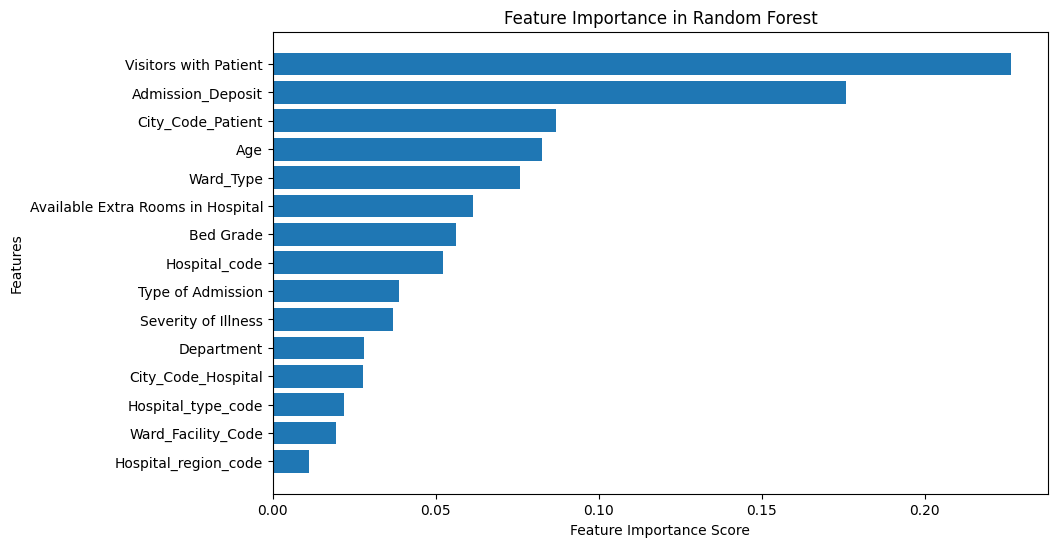

In [ ]:

feature_importances = rf_classifier.feature_importances_


feature_names = X_test_final_df.columns 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  
plt.show()




Random Forest After doing Feature selection

In [17]:
features_to_drop = ['Hospital_code', 'Hospital_type_code', 'City_Code_Hospital', 
                     'Ward_Type', 'City_Code_Patient']

In [18]:
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


scaler = StandardScaler()


X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)       




X_train_reduced = scaler.fit_transform(X_train.drop(columns=features_to_drop))
X_test_reduced = scaler.transform(X_test.drop(columns=features_to_drop))




In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)


rf_classifier.fit(X_train_reduced, y_train)


y_pred = rf_classifier.predict(X_test_reduced)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

           1       0.34      0.13      0.18      4721
           2       0.38      0.47      0.42     15628
           3       0.40      0.59      0.48     17498
           4       0.34      0.21      0.26     11032
           5       0.00      0.00      0.00      2349
           6       0.35      0.43      0.38      7004
           7       0.00      0.00      0.00       549
           8       0.32      0.02      0.03      2051
           9       0.33      0.05      0.09       967
          10       0.20      0.00      0.00       553
          11       0.49      0.40      0.44      1336

    accuracy                           0.38     63688
   macro avg       0.29      0.21      0.21     63688
weighted avg       0.35      0.38      0.35     63688



It looks like those features did have an impact 